# An example of using candex with rotated Latitude and Longitude (every grid has it own lat and lon)
## Remapping of CONUS WRF to subbasins of South Saskatchewan River at Medicine Hat, Alberta, Canada.

In [1]:
# loading candex
from candex.candex import candex

# initializing candex object
cndx = candex()

# specifying candex objects
# name of the case; the temporary, remapping and remapped file names include case name
cndx.case_name                = 'WRF_Medicine_Hat_resample'
# temporary path that the candex generated GIS files and remapped file will be saved
cndx.temp_dir                 = '../temporary/'
# name of target shapefile that the source netcdf files should be remapped to
cndx.target_shp               = '../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp'
# name of netCDF file(s); multiple files can be specified with *
cndx.source_nc                = '../data/Source_nc_WRF/WRF*.nc'
# name of variables from source netCDF file(s) to be remapped
cndx.var_names                = ['T2']
# name of variable longitude in source netCDF files
cndx.var_lon                  = 'XLONG'
# name of variable latitude in source netCDF files
cndx.var_lat                  = 'XLAT'
# name of variable time in source netCDF file; should be always time
cndx.var_time                 = 'time'
# location where the remapped netCDF file will be saved
cndx.output_dir               = '../output/'
# format of the variables to be saved in remapped files,
# if one format provided it will be expanded to other variables
cndx.format_list              = ['f4']
# fill values of the variables to be saved in remapped files,
# if one value provided it will be expanded to other variables
cndx.fill_value_list          = ['-9999.00']
# if exists and uncommented candex will use this remapping info and skip GIS tasks
#cndx.remap_csv                = '../temporary/WRF_Medicine_Hat_remapping.csv'

# execute candex
cndx.get_col_row()


candex detects case 2 - rotated lat/lon


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

lon = np.arange(-118, -110, 0.0625)
lat = np.arange(  48,   52, 0.0625)
lon, lat = np.meshgrid(lon, lat)
lon_mesh_1D = lon.flatten()
lat_mesh_1D = lat.flatten()
ID_mesh_1D  = np.arange(len(lon_mesh_1D))+1
#print(len(ID_mesh_1D))

# load the lat lon from nc file
ds          = xr.open_dataset('../data/Source_nc_WRF/WRF_merged_2000-10-01.nc')
lon_nc      = np.array(ds['XLONG'])
lat_nc      = np.array(ds['XLAT'])
ID_nc       = np.arange(lat_nc.size)+1
ID_nc       = ID_nc.reshape(lat_nc.shape)

## initialize the varibale
lat_source  = np.empty(0)
lon_source  = np.empty(0)
ID_source   = np.empty(0)
W           = np.empty(0)
lat_target  = np.empty(0)
lon_target  = np.empty(0)
ID_target   = np.empty(0)

for i in np.arange(len(lon_mesh_1D)):
    
    #print(i)
    
    D = ((lon_mesh_1D[i]-lon_nc)**2 + (lat_mesh_1D[i]-lat_nc)**2)**0.5
    
    D_inv = 1/D
        
    idx, idy = np.where(D_inv>4)
    
    # get the lengh of idx
    # source lat
    lat_source_temp  =  lat_nc [idx, idy]
    lon_source_temp  =  lon_nc [idx, idy]
    W_temp           =  D_inv  [idx, idy] / sum(D_inv  [idx, idy])
    #print(len(D_inv  [idx, idy]))
    
    #
    ID_source_temp   = ID_nc  [idx, idy]
    lat_target_temp  = np.repeat(lat_mesh_1D[i], len(W_temp))
    lon_target_temp  = np.repeat(lon_mesh_1D[i], len(W_temp))
    ID_target_temp   = np.repeat(ID_mesh_1D[i], len(W_temp))
    
    # 
    lat_source = np.append(lat_source, lat_source_temp)
    lon_source = np.append(lon_source, lon_source_temp)
    ID_source  = np.append(ID_source, ID_source_temp )
    W          = np.append(W, W_temp)
    lat_target = np.append(lat_target, lat_target_temp)
    lon_target = np.append(lon_target, lon_target_temp)
    ID_target  = np.append(ID_target, ID_target_temp)
    

    
df = pd.DataFrame()
df ['ID_s']   = ID_source
df ['lat_s']  = lat_source
df ['lon_s']  = lon_source
df ['ID_t']   = ID_target
df ['lat_t']  = lat_target
df ['lon_t']  = lon_target
df ['weight'] = W

df ['cols'] = np.nan
df ['rows'] = np.nan


#print(df)


df2 = pd.read_csv(cndx.col_row_name)

for index, row in df2.iterrows():
    
    
    #print(row.lat_s, row.lon_s)
    
    idx_lat = np.where(abs(lat_source-row.lat_s) < 0.0001)
    idx_lon = np.where(abs(lon_source-row.lon_s) < 0.0001)
    
    idx = np.intersect1d (idx_lat, idx_lon)
    
    #print(idx)
    
    if len(idx) > 0:
    
        df.cols.iloc[idx] = row.cols
        df.rows.iloc[idx] = row.rows
    
#     print(df_temp)
#     df_temp = df_temp [df_temp['lon_s_int'] - row.lon_s < 0.0001]
#     print(df_temp)
#     lll

#print(df)

df ['candex_case'] = 2


# df2 = pd.read_csv(cndx.name_of_row_col_file)
# print(df2)

# new_df = pd.merge(df, df2,  how='left', left_on=['lat_s_int','lon_s_int'], right_on = ['lat_s','lon_s'])

# new_df = pd.merge(df, df2,  how='left', left_on=['ID_s_int'], right_on = ['lat_s','lon_s'])

# print(new_df)
    


In [3]:


df.to_csv('../temporary/WRF_Medicine_Hat_resample_remapping_manual.csv')


In [4]:
# loading candex
from candex.candex import candex

# initializing candex object
cndx = candex()

# specifying candex objects
# name of the case; the temporary, remapping and remapped file names include case name
cndx.case_name                = 'WRF_Medicine_Hat_resample'
# temporary path that the candex generated GIS files and remapped file will be saved
cndx.temp_dir                 = '../temporary/'
# name of target shapefile that the source netcdf files should be remapped to
cndx.target_shp               = '../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp'
# name of netCDF file(s); multiple files can be specified with *
cndx.source_nc                = '../data/Source_nc_WRF/WRF*.nc'
# name of variables from source netCDF file(s) to be remapped
cndx.var_names                = ['T2']
# name of variable longitude in source netCDF files
cndx.var_lon                  = 'XLONG'
# name of variable latitude in source netCDF files
cndx.var_lat                  = 'XLAT'
# name of variable time in source netCDF file; should be always time
cndx.var_time                 = 'time'
# location where the remapped netCDF file will be saved
cndx.output_dir               = '../output/'
# format of the variables to be saved in remapped files,
# if one format provided it will be expanded to other variables
cndx.format_list              = ['f4']
# fill values of the variables to be saved in remapped files,
# if one value provided it will be expanded to other variables
cndx.fill_value_list          = ['-9999.00']
# if exists and uncommented candex will use this remapping info and skip GIS tasks
cndx.remap_csv                = '../temporary/WRF_Medicine_Hat_resample_remapping_manual.csv'

# execute candex
cndx.run_candex()



no author name is provide and the author name is changed to (author name)!
remap file is provided; candex will use this file and skip calculation of remapping
candex case exists in the remap file
candex detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
candex detects that all the varibales have dimensions of:
['time', 'y', 'x']
candex detects that the longitude varibales has dimensions of:
['y', 'x']
candex detects that the latitude varibales has dimensions of:
['y', 'x']
------REMAPPING------
int32
Remapping ../data/Source_nc_WRF/WRF_merged_2000-10-01.nc to ../output/WRF_Medicine_Hat_resample_remapped_2000-10-01-00-00-00.nc
Started at date and time 2021-03-29 17:02:24.876762
Ended   at date and time 2021-03-29 17:02:25.717413
------


--------------
--------------
# Visualization of the source and the results

<xarray.Dataset>
Dimensions:      (time: 24, x: 199, y: 168)
Coordinates:
  * time         (time) datetime64[ns] 2000-10-01 ... 2000-10-01T23:00:00
    XLONG        (y, x) float64 ...
    XLAT         (y, x) float64 ...
Dimensions without coordinates: x, y
Data variables:
    I_RAINNC     (time, y, x) float64 ...
    LWDNB        (time, y, x) float32 ...
    P            (time, y, x) float32 ...
    PREC_ACC_C   (time, y, x) float32 ...
    PREC_ACC_NC  (time, y, x) float32 ...
    Q2           (time, y, x) float32 ...
    RAINC        (time, y, x) float32 ...
    RAINNC       (time, y, x) float32 ...
    SWDNB        (time, y, x) float32 ...
    T2           (time, y, x) float32 ...
    U10          (time, y, x) float32 ...
    V10          (time, y, x) float32 ...
(33432,)
<xarray.Dataset>
Dimensions:    (ID: 8192, time: 24)
Coordinates:
  * time       (time) datetime64[ns] 2000-10-01 ... 2000-10-01T23:00:00
  * ID         (ID) float64 1.0 2.0 3.0 4.0 ... 8.19e+03 8.191e+03 8.192e+03

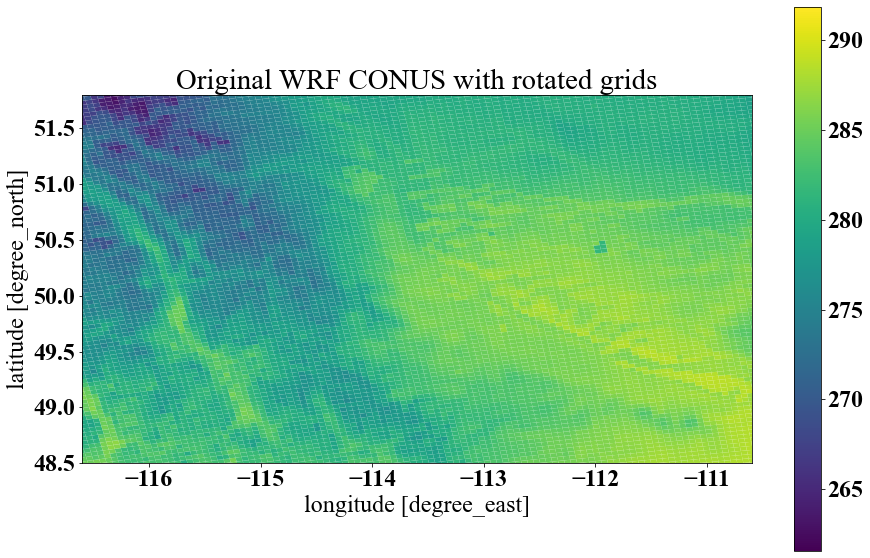

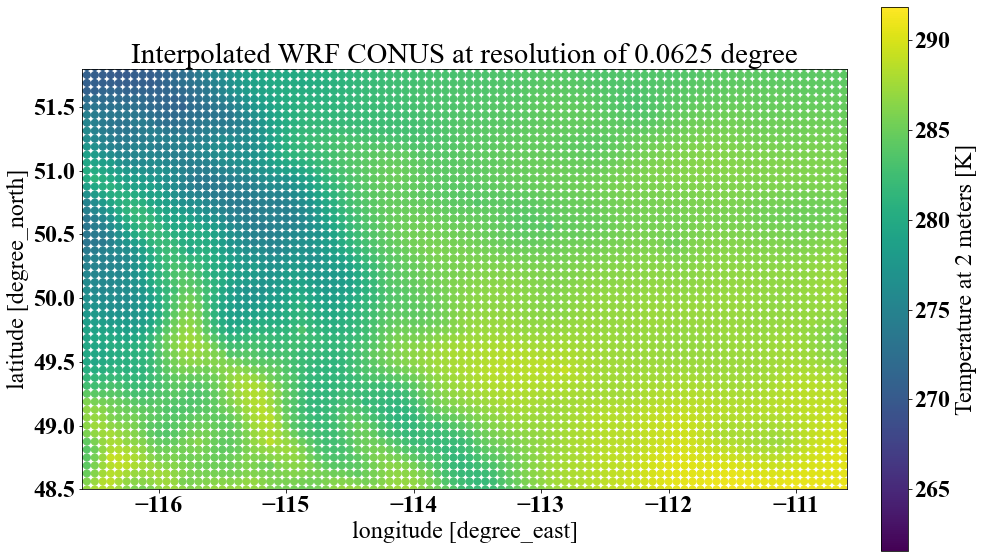

In [5]:
# visualize the result
import geopandas as gpd
import xarray as xr
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)



# visualize the original netCDF for the first file, first time step
shp_source = gpd.read_file('../temporary/WRF_Medicine_Hat_source_shapefile.shp') # load the target shapefile
# load the infromation on the
nc_names = sorted(glob.glob ('../data/Source_nc_WRF/WRF*.nc'))
ds       = xr.open_dataset(nc_names[0]) # the first netcdf file
print(ds)
T2       = np.array(ds.T2 [3,:,:]).flatten() # the first time frame of the first 
print(T2.shape)
lat      = np.array(ds.XLAT).flatten()  # the first time frame of the first 
lon      = np.array(ds.XLONG).flatten()  # the first time frame of the first 

lat_shp = shp_source ['lat_s']
lon_shp = shp_source ['lon_s']
idx = np.zeros(len(lat_shp))
value = np.zeros(len(lat_shp))

for i in np.arange(len(lat_shp)):
    # find the row of the shapefile that is closes to the point
    diff = abs(lat-lat_shp[i])+ abs(lon-lon_shp[i])
    temp = np.where(diff == np.min(diff))
    idx[i] = temp[0].astype(int)
    a = idx[i]
    value[i] = T2 [a.astype(int)]


shp_source ['value'] = value

max_T2 = max(value)
min_T2 = min(value)


f, axes = plt.subplots(1,1,figsize=(15,10))
shp_source.plot(column='value', ax = axes, legend=True)
plt.xlim([-116.6 , -110.6 ])
plt.ylim([48.5 , 51.8 ])

plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.title('Original WRF CONUS with rotated grids')

plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('../fig/Example5_A.png')

# 

f, axes = plt.subplots(1,1,figsize=(15,10) )
plt.xlim([-116.6 , -110.6 ])
plt.ylim([48.5 , 51.8 ])

ds = xr.open_dataset('../output/WRF_Medicine_Hat_resample_remapped_2000-10-01-00-00-00.nc')
print(ds)

lat = ds.latitude
lon = ds.longitude
T2  = ds.T2.isel(time=23) # the last time step

sc =plt.scatter(lon, lat, s=50, c=np.array(T2), vmin=min_T2, vmax=max_T2)
ax_cbar = plt.colorbar(sc,fraction=0.046, pad=0.04)
ax_cbar.set_label('Temperature at 2 meters [K]')

plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.title('Interpolated WRF CONUS at resolution of 0.0625 degree')
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('../fig/Example5_B.png')



